In [2]:
import speech_recognition as sr
from os import path
import subprocess
import sys
def speech_recognizer(path,file,start=0.0,end=0):
    try:
        os.remove(path+"/videos/out.wav")
    except OSError:
        pass

    filename = file.split('.')[0]
    if(end>0):
        start = start - 1.0
        command = "ffmpeg -i "+ path+"/videos/"+file+" -ss "+str(start)+" -to "+str(end)+" -acodec copy "+path+"/videos/out.wav"
        subprocess.call(command, shell=True)
        AUDIO_FILE =  "out.wav"
    elif end == 0:
        AUDIO_FILE =  file       
    r = sr.Recognizer()
    with sr.AudioFile(path+"/videos/"+AUDIO_FILE) as source:
        r.adjust_for_ambient_noise(source)
        audio = r.record(source)  # read the entire audio file

    try:
        r = r.recognize_sphinx(audio)
        print r
        return r
    except sr.UnknownValueError:
       # os.remove("out.wav")
        print("Sphinx could not understand audio")
        return 
    except sr.RequestError as e:
       # os.remove("out.wav")
        print("Sphinx error; {0}".format(e))
        return


def extract_audio(filename, channels=1, rate=44100):
    temp = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
    if not os.path.isfile(filename):
        print ("The given file does not exist: {0}".format(filename))
        raise Exception("Invalid filepath: {0}".format(filename))
    if not which("ffmpeg"):
        print ("ffmpeg: Executable not found on machine.")
        raise Exception("Dependency not found: ffmpeg")
    command = ["ffmpeg", "-y", "-i", filename, "-ac", str(channels), "-ar", str(rate), "-loglevel", "error", temp.name]
    use_shell = True if os.name == "nt" else False
    subprocess.check_output(command, stdin=open(os.devnull), shell=use_shell)
    return temp.name, rate





In [3]:

def percentile(arr, percent):
    arr = sorted(arr)
    k = (len(arr) - 1) * percent
    f = math.floor(k)
    c = math.ceil(k)
    if f == c: return arr[int(k)]
    d0 = arr[int(f)] * (c - k)
    d1 = arr[int(c)] * (k - f)
    return d0 + d1



In [10]:
import subprocess, sys
from pytube import YouTube
import pysrt
import os
import shutil
import requests
from __future__ import absolute_import, print_function, unicode_literals
import argparse
import audioop
import json
import math
import multiprocessing
import os
import requests
import subprocess
import sys
import tempfile
import wave

path = os.getcwd()
if not os.path.exists(os.path.dirname(path+"/videos/")):
    os.makedirs(os.path.dirname(path+"/videos/"))

if not os.path.exists(os.path.dirname(path+"/videos_text/")):
    os.makedirs(os.path.dirname(path+"/videos_text/"))

def autosub_func(path,name,srt,lan):     
    command = "python /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/autosub/autosub_app.py -S en -D en  "+path+"/videos/"+name
    subprocess.call(command, shell=True)
    srt = srt.replace("_"+lan,"")
    print("!!!!!!!!!!")
    print (srt)
    shutil.move(path+"/videos/"+srt, path+"/videos_text/"+srt.split('.')[0].strip()+"_"+lan+".srt")

def cmu(path,file,srt):
#    filename ,rate = extract_audio(path+"/videos/"+file)
    print (srt)
    filename = srt.split('.srt')[0].strip()+".wav"
    print (filename,file)
    command = "ffmpeg -i "+path+"/videos/"+file+" -ab 160k -ac 2 -ar 44100 -vn "+path+"/videos/"+filename
    subprocess.call(command, shell=True)
    regions = find_speech_regions(path+"/videos/"+filename)
    with open(path+"/videos_text/"+srt,"w+") as writer:
        for i in range(0,len(regions)):
            recognizer = speech_recognizer(path,filename,regions[i][0],regions[i][1])
            writer.write("%s\n"%str(i+1))                
            sec, micro = str(regions[i][0]).split('.')
            m, s = divmod(int(sec), 60)
            h, m = divmod(m, 60)
            time= "{:02}:{:02}:{:02},{}".format(h,m,s,micro)
            writer.write("%s"%time)        
            writer.write(" --> ")
            sec, micro = str(regions[i][1]).split('.')
            m, s = divmod(int(sec), 60)
            h, m = divmod(m, 60)
            time1= "{:02}:{:02}:{:02},{}".format(h,m,s,micro)
            writer.write("%s"%time1)
            writer.write("\n")
            writer.write("%s"%recognizer)
            writer.write("\n\n")

    

def download_file(path,url):
    vid_form = [".3G2",".3GP",".ASF",".AVI",".FLV",".M4V",".MOV",".MP4",".MPG",".RM",".SRT",".SWF",".VOB",".WMV",".webm"]
    flag=0
    local_filename = url.split('/')[-1]

    for i in vid_form:
        if i.lower() in local_filename:
            flag =1
            x = local_filename.split(i.lower())[0]+i.lower()
    if flag==1:
        r = requests.get(url, stream=True)
        with open(path+"/videos/"+x, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    else:
        x = local_filename+".mp4"
        r = requests.get(url, stream=True)
        with open(path+"/videos/"+x, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    return x
def video_to_text(name):
    lan = name[:2]
    name = name[2:]
    
    ################################ Downlaoding from Youtube ##################################
    if "yout" in name:
        out_name =  name.split('/')[-1]+".mp4"
        cmd = "youtube-dl -o "+path+"/videos/"+out_name+" -f mp4 " + name
        subprocess.call(cmd, shell=True)
    ################################ Downlaoding from A Given Video-Link ##################################
    elif "https://" in name:
        out_name = download_file(path,name) 
    ################################ From the local file ##################################
    else:
        try:
            out_name = name.replace(".com","").replace(" ","_")
            print(out_name)
            os.rename(path+"/videos/"+name,path+"/videos/"+out_name)
        except:
            out_name=name
        
    srt = out_name.split('.')[0].strip()+"_"+lan+".srt"  
    print (srt)
    if lan == 'in':
        print ("inside autosub")
        autosub_func(path,out_name,srt,lan)
        return get_srt_to_txt(path,srt)
    if lan == 'us':
        print ("inside cmu")
        #cmu(path,out_name,srt)
   #     filename,rate = extract_audio(path+"/videos/"+out_name)
        filename = srt.split('.srt')[0].strip()+".wav"
        print("out_name",out_name)
        command = "ffmpeg -i "+path+"/videos/"+out_name+" -ab 160k -ac 2 -ar 44100 -vn "+path+"/videos/"+filename
        subprocess.call(command, shell=True)
        return speech_recognizer(path,filename)


def get_srt_to_txt(path,srt):
    sub=""
    subs = pysrt.open(path+"/videos_text/"+srt, encoding='iso-8859-1')
    text = open(path+"/videos_text/"+srt.split('.srt')[0].strip()+".txt","wb+")
    txt = subs[0].text
    sub_len = len(subs)
    for i in range(1,sub_len):
        if ((subs[i].start.minutes*60*1000 + subs[i].start.seconds*1000+subs[i].start.milliseconds) - ((subs[i-1].end.minutes*60*1000 + subs[i-1].end.seconds*1000+subs[i-1].end.milliseconds))) < 500: 
            txt = txt + " "+subs[i].text.lower()
        else:
            txt = txt + ". "
            text.write(txt)
            sub = sub +txt
            txt = subs[i].text
    if sub =="":
        return "No subtitles formed"

    return sub




In [78]:
text="Kristoff with soldering iron in this video I will be about the six main criteria death make or break form design in quarry. Korean colours. Interface update camera quality battery life and try starting right now infra 17 a few interesting new things happened to fall for bigger and entellus cream. And II will forget very expensive. And the most expensive of them all is the new iPhone 10. Apple's $1,000 iPhone looks. Quizzes for the knot. It is especially important but you get used to that would cut out. That is also a fake Id is on the iPhone 10. The new three face recognition system works surprisingly well in many cases but it is a slower in a bit less accurate. Fingerprint scanner. IPhone has a good looking design screen look gorgeous it is guaranteed to get software update for long time restaurants near me and has a great camera. Battery life is just average stomach virus going to sony iphone 8 plus nios ii has going to notifications my phone i am just rest for the $1,000. And then there be iPhone 8 and iPhone. Suppose you have just call them this 7s and 7s Plus stable comma exactly like last year's iphone. Paytm cashback. Yes the design is a bit boring but it option. Vaibhav improving to main area. Performance with appointments. Is the fastest on any phone emirates how to add yaar really stunning colours. Ambattur wondering the main camera selfie. Beautiful photo as on the iPhone 10. And one more thing the new iphone now supports wireless charging it might be nice but it's slower than what is charging and you cant use your phone was charging we go straight to the land of the free android with the samsung galaxy note 8. That it has one unit t-shirt espn spouses cold enough it was great. Great phone overall has two cameras in shrewsbury good looking for teachers. It has a stylish glass and metal body NS short super good looking screen and solid battery life. Smoke effect no phone is. The know that my baby. Beck so many people coc new 8000 dollars. IPhone and don't expect get android update directly google pixel 2 xl does form ever made basna. The main reason for that is the screen is so matte screen did get it pursuant when is the fox life. NS suffers from Britain an issue with all outlets space very quickly on the pic. How to excel. YouCam perfect screen the pixel 2 XL is it we fall. Buttery smooth performance latest android software jayanti day 1 update and for me a best camera ever put on a phone it's too pricey but cops versus iphone 10 and the note. LG v30 is the best phone LG has ever made. It's our favourite. When it comes piggy bank with basil. The LG v30 has mh12 play almost no bezel no not know cause no interruption. Hey beautiful birth wishes to somebody song with ly dishes with colours this is not is better than the pixel 2 xl but it's too something to know about. Royal digital if interest rate is not perfect text book it is function. If it is very good picture sent know what a fraction form has it super wide angle camera. Ravi Taori also look stylish relation has a baba farid battery life. The oneplus 5t. Paper for the ball flagship phone it is just that for half the price of the policy of just mention. Oneplus 5t delivery similar performance. It has H2H beautiful 6 inch amoled screen has a very fast rashmi performance. It has a stylish metal design in solid battery life. If camera is the only thing that is not buy that girl is another flagship. What is definite too far behind don't forget that the oneplus 5t she is only $4 mv not working hd images like verizon. Springdale United States. Great phone you should not miss is the word made santro vivacious is it wrong to become the world's biggest homemaker. Find Apple and Samsung and the mate 10 pro is is most who is the phone. It is a big phone with a trendy basil extreme stylish glass and metal design islamic colours it has a good looking this play has longer battery life then moves from this place. Now is custom Android interface just take without getting used to super functional and if you want to be different this is a solid choice. There are a few other options keep in mind. Samsung Galaxy S8 Galaxy yes it was her now so that big discount tangled 2 full form premium design in great cameras smart price. The smaller pixel 2 has an amazing camera and doesn't cost proportion was it has no display issues white sibling. Go to excel. Combine this with buttermilk performance and the guarantee for Dev on Android update. And this is our phone worth considering. Finally there is the essential phone. Don't be so for just $450 the essential phone is essentially a steel. It is one of the best designs of 2017 within a split screen in a very compact body scratch resistant ceramic back like no other means she found it is getting software updates on a very regular basis. Is too doesn't have a great camera but if you're willing to deal with a mediocre camera it's a great and very affordable option. These are all favourite phones of 2017 birthday many more worth considering phone by sony show me motorola in many others did not make it in this list define options. So. What is your favourite phone of the year. What is your favourite new feature what is the thing that most love about it."

In [19]:
speech_recognizer(path,"out_us.wav")

''

In [80]:
text="uswatch?v=Meif6leYjmc.mp4"

In [71]:
text[2:]

u'2014 Mercedes-Benz C200 _ Expert Review _ CarDekho.com-kvAKyNYy1_A.mp4'

In [84]:
print (text)

uswatch?v=Meif6leYjmc.mp4


In [85]:
from pydub import AudioSegment
from pydub.playback import play

In [89]:
sound_stereo = AudioSegment.from_file("videos/index_us_us.wav", format="mp3")
sound_monoL = sound_stereo.split_to_mono()[0]
sound_monoR = sound_stereo.split_to_mono()[1]


In [90]:
sound_monoR_inv = sound_monoR.invert_phase()

In [91]:
sound_CentersOut = sound_monoL.overlay(sound_monoR_inv)

In [92]:
fh = sound_CentersOut.export("new_file.mp3", format="mp3")

In [94]:
fh = sound_monoR.export("new_file_R.mp3", format="mp3")

In [95]:
fh = sound_monoL.export("new_file_L.mp3", format="mp3")

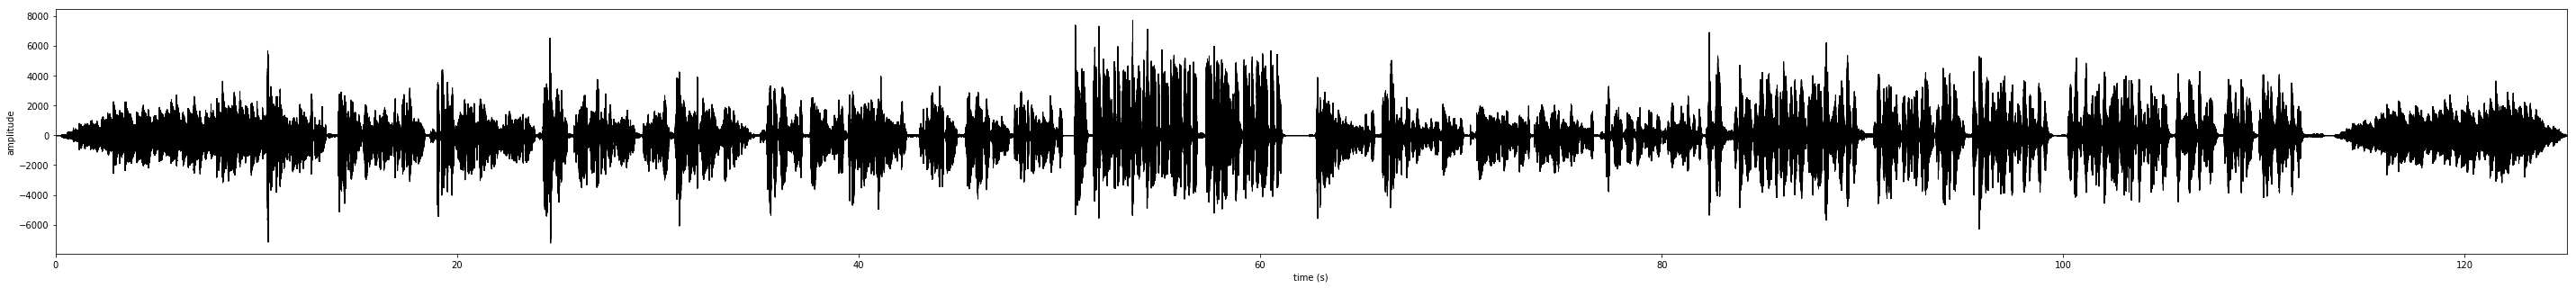

In [99]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
import numpy as np

# Load the data and calculate the time of each sample
samplerate, data = wavfile.read('videos/index_us_us.wav')
times = np.arange(len(data))/float(samplerate)

# Make the plot
# You can tweak the figsize (width, height) in inches
plt.figure(figsize=(50, 5))
plt.fill_between(times, data[:,0], data[:,1], color='k') 
plt.xlim(times[0], times[-1])
plt.xlabel('time (s)')
plt.ylabel('amplitude')
# You can set the format by changing the extension
# like .pdf, .svg, .eps
#plt.savefig('plot.png', dpi=100)
plt.show()

In [5]:
sec, micro = 10,4954195011
m, s = divmod(int(sec), 60)
h, m = divmod(m, 60)
time= "{:02}:{:02}:{:02},{}".format(h,m,s,micro)
 

In [13]:
micro = int(str(micro)[:3])

In [14]:
(micro)

495

In [15]:
import pandas as pd


In [16]:
x =pd.read_csv("dict.txt")

ParserError: Error tokenizing data. C error: Expected 1 fields in line 261393, saw 3


In [20]:
import speech_recognition as sr
from os import path
import subprocess
import sys
def find_speech_regions(filename, frame_width=4096, min_region_size=8, max_region_size=15):
    reader = wave.open(filename)
    sample_width = reader.getsampwidth()
    rate = reader.getframerate()
    n_channels = reader.getnchannels()
    chunk_duration = float(frame_width) / rate

    n_chunks = int(math.ceil(reader.getnframes()*1.0 / frame_width))
    energies = []

    for i in range(n_chunks):
        chunk = reader.readframes(frame_width)
        energies.append(audioop.rms(chunk, sample_width * n_channels))

    threshold = percentile(energies, 0.2)

    elapsed_time = 0

    regions = []
    region_start = None
    #print energies
    for energy in energies:
        
        is_silence = energy <= threshold
        max_exceeded = region_start and elapsed_time - region_start >= max_region_size

        if (max_exceeded or is_silence) and region_start:
           # print energy
            if elapsed_time - region_start >= min_region_size:
                regions.append((region_start, elapsed_time))
                #print regions,"region"
                region_start = elapsed_time

        elif (not region_start) and (not is_silence):
            #print elapsed_time,"elasped_start"
            region_start = elapsed_time
            #print region_start,"start"
        elapsed_time += chunk_duration
    return regions
def add_sil(wav):
    from pydub import AudioSegment
    from pydub.playback import play

    audio_in_file = wav

    # create 1 sec of silence audio segment
    one_sec_segment = AudioSegment.silent(duration=2000)  #duration in milliseconds
    print (one_sec_segment)
    #read wav file to an audio segment
    song = AudioSegment.from_wav(audio_in_file)

    #Add above two audio segments    
    final_song = one_sec_segment + song + one_sec_segment

    #Either save modified audio
    final_song.export(audio_in_file, format="wav")
    
def split_autosub(filename,file):
    txt =""
    cmd = "youtube-dl -o "+filename+" -f mp4 " + file
    subprocess.call(cmd, shell=True)
    print (filename,file)
    wav_file = filename.split('.mp4')[0]+".wav"
    command = "ffmpeg -i "+filename+" -ab 160k -ac 1 -ar 16000 "+wav_file
    subprocess.call(command, shell=True)
    regions = find_speech_regions(wav_file)
    for i in range(0,len(regions)): 
        command = "ffmpeg -i "+ wav_file+" -ss "+str(regions[i][0])+" -to "+str(regions[i][1])+" -acodec copy out.wav"
        subprocess.call(command, shell=True)
        add_sil("out.wav")
        command = "autosub -S en -D en out"+str(i)+".wav"
        subprocess.call(command, shell=True)
        srt = "out.srt"
        subs = pysrt.open(srt, encoding='iso-8859-1')
        txt = txt+ subs[0].text+" "
        try:
            os.remove("out.srt")
            os.remove("out.wav")
        except:
            pass
            
        
 
        

from pydub import AudioSegment
import glob,os
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms




In [6]:
split_autosub("daddji.mp4","https://youtu.be/cuaZ1Ba8eZ8")

daddji.mp4 https://youtu.be/cuaZ1Ba8eZ8
